Word2Vec_Back2Basic
============

03. NAVER 뉴스의 Doc2vec 적용
-------------------------

---

## 네이버 뉴스 분류 with doc2vec  
#### (feat. [Gensim](http://radimrehurek.com/gensim/))

In [4]:
def read_data(filename):
    with open(filename, 'r') as f:
        data = [line.split('\t') for line in f.read().splitlines()]
        data = data[1:]   # header 제외
    return data

In [5]:
# load
with open('../word2vec/train_docs_save.txt?dl=1', 'rb') as rd:
    train_docs = pickle.load(rd)
    
with open('../word2vec/test_docs_save.txt?dl=1', 'rb') as rd:
    test_docs = pickle.load(rd)

In [6]:
TaggedDocument = namedtuple('TaggedDocument', 'words tags')

In [7]:
tagged_train_docs = [TaggedDocument(d, [c]) for d, c in train_docs]
tagged_test_docs = [TaggedDocument(d, [c]) for d, c in test_docs]

---

### Model parameters 설명

<h4>Bases: gensim.models.word2vec.Word2Vec</h4>

parameters | explain
:-----------|:----------------------------------
dm | defines the training algorithm. By default (dm=1), ‘distributed memory’ (PV-DM) is used. Otherwise, distributed bag of words (PV-DBOW) is employed.
size | is the dimensionality of the feature vectors.
window | is the maximum distance between the predicted word and context words used for prediction within a document.
alpha | is the initial learning rate (will linearly drop to min_alpha as training progresses).
seed | for the random number generator
min_count | ignore all words with total frequency lower than this.
max_vocab_size | limit RAM during vocabulary building
sample | threshold for configuring which higher-frequency words are randomly downsampled; * default is 1e-3, values of 1e-5 (or lower) may also be useful, value 0. disable downsampling. 
workers | use this many worker threads to train the model
hs | if 1, hierarchical softmax will be used for model training. If set to 0 (default), and negative is non-zero, negative sampling will be used.
negative | if > 0, negative sampling will be used, the int for negative specifies how many “noise words” should be drawn (usually between 5-20). Default is 5. If set to 0, no negative samping is used.
dm_mean | if 0 (default), use the sum of the context word vectors. If 1, use the mean. Only applies when dm is used in non-concatenative mode.
dm_concat | if 1, use concatenation of context vectors rather than sum/average; default is 0 (off). Note concatenation results in a much-larger model, as the input is no longer the size of one (sampled or arithmetically combined) word vector, but the size of the tag(s) and all words in the context strung together.
dm_tag_count | expected constant number of document tags per document, when using dm_concat mode; default is 1.
dbow_words | if set to 1 trains word-vectors (in skip-gram fashion) simultaneous with DBOW doc-vector training; default is 0 (faster training of doc-vectors only).
trim_rule | vocabulary trimming rule, specifies whether certain words should remain in the vocabulary, be trimmed away, or handled using the default (discard if word count < min_count). Can be None (min_count will be used), or a callable that accepts parameters (word, count, min_count) and returns either util.RULE_DISCARD, util.RULE_KEEP or util.RULE_DEFAULT. Note: The rule, if given, is only used prune vocabulary during build_vocab() and is not stored as part of the model.



#### DBOW가 좋다고 한다.  [Doc2Vec to wikipedia articles](https://markroxor.github.io/gensim/static/notebooks/doc2vec-wikipedia.html)

* 작은 데이터에서는 CBOW 종류의 모델링이 더 좋고 큰 데이터에서는 SG 종류의 모델링이 더 좋다고 한다.

### Model building

In [8]:
import multiprocessing
cores = multiprocessing.cpu_count()

In [9]:
# 사전 구축
doc_vectorizer = doc2vec.Doc2Vec(
    dm=0,            # PV-DBOW / default 1
    dbow_words=0,    # w2v simultaneous with DBOW d2v / default 0
    window=5,        # distance between the predicted word and context words 
    size=500,        # vector size 
    alpha=0.025,     # learning-rate
    
    seed=1234,
    
    min_count=10,    # 너무 적게나온 단어 제거
    min_alpha=0.025, # min learning-rate
    workers=cores,   # 멀티 쓰레드
    sample=1e-5,    #  Subsampling Frequent Words 너무 많이 나온단어 빈도 줄이기
    hs=0,          # hierarchical softmax / default 0
    negative=5   # negative sampling / default 5
    )

doc_vectorizer.build_vocab(tagged_train_docs)
print(str(doc_vectorizer))

Doc2Vec(dbow,d500,n5,mc10,s1e-05,t24)


### Model Training

In [10]:
for epoch in range(10):
    %time doc_vectorizer.train(tagged_train_docs)
    doc_vectorizer.alpha -= 0.002  # decrease the learning rate
    doc_vectorizer.min_alpha = doc_vectorizer.alpha  # fix the learning rate, no decay

CPU times: user 12min 51s, sys: 27.6 s, total: 13min 18s
Wall time: 5min 3s
CPU times: user 12min 22s, sys: 25.2 s, total: 12min 47s
Wall time: 4min 53s
CPU times: user 12min 27s, sys: 25.5 s, total: 12min 52s
Wall time: 4min 55s
CPU times: user 12min 25s, sys: 25.8 s, total: 12min 51s
Wall time: 4min 56s
CPU times: user 12min 13s, sys: 25 s, total: 12min 38s
Wall time: 4min 52s
CPU times: user 12min 12s, sys: 25.5 s, total: 12min 38s
Wall time: 4min 52s
CPU times: user 12min 17s, sys: 25.6 s, total: 12min 43s
Wall time: 4min 54s
CPU times: user 12min 15s, sys: 25.6 s, total: 12min 40s
Wall time: 4min 53s
CPU times: user 12min 14s, sys: 25.9 s, total: 12min 40s
Wall time: 4min 54s
CPU times: user 12min 16s, sys: 26.2 s, total: 12min 42s
Wall time: 4min 54s


In [11]:
print("Total Time :", doc_vectorizer.total_train_time // 60, "분")

Total Time : 49.0 분


### Save

In [12]:
# To save
doc_vectorizer.save('../word2vec/model/NAVER_POS_ns.model')

### Load

In [ ]:
# load
doc_vectorizer = doc2vec.Doc2Vec.load('../word2vec/model/NAVER_POS_ns.model')

---

제대로 학습 됐는지 확인

In [14]:
from pprint import pprint
# 정치
pprint(doc_vectorizer.most_similar('최순실/Noun'))

[('야적/Noun', 0.1830592155456543),
 ('이만기/Noun', 0.1745276302099228),
 ('레이첼/Noun', 0.1745268851518631),
 ('Welcome/Alpha', 0.17028766870498657),
 ('최미영/Noun', 0.1670311540365219),
 ('블루마운틴/Noun', 0.16587799787521362),
 ('월일/Noun', 0.16276158392429352),
 ('media09@kmib.co.kr/Email', 0.16262292861938477),
 ('수상실/Noun', 0.16255681216716766),
 ('TV/Alpha', 0.16252344846725464)]


In [15]:
# 경제
pprint(doc_vectorizer.most_similar('자본/Noun'))

[('김명환/Noun', 0.20540522038936615),
 ('황열/Noun', 0.17703355848789215),
 ('모장/Noun', 0.17611414194107056),
 ('토드/Noun', 0.17185772955417633),
 ('과자류/Noun', 0.17111030220985413),
 ('부사관/Noun', 0.1711048036813736),
 ('나이아가라/Noun', 0.16785165667533875),
 ('당산역/Noun', 0.16722515225410461),
 ('김승욱/Noun', 0.16651955246925354),
 ('푸르지오/Noun', 0.16648687422275543)]


In [16]:
# 사회
pprint(doc_vectorizer.most_similar('청소년/Noun'))

[('산자/Noun', 0.2146463245153427),
 ('위성/Noun', 0.18768556416034698),
 ('어지럼증/Noun', 0.18348631262779236),
 ('한음/Noun', 0.17496606707572937),
 ('헌팅턴/Noun', 0.17378512024879456),
 ('불로소득/Noun', 0.17353197932243347),
 ('File/Alpha', 0.17327725887298584),
 ('•/Foreign', 0.17058712244033813),
 ('식물학/Noun', 0.16980265080928802),
 ('차폐벽/Noun', 0.16979628801345825)]


In [17]:
# 문화
pprint(doc_vectorizer.most_similar('박물관/Noun'))

[('glass/Alpha', 0.20444463193416595),
 ('서든어택/Noun', 0.19237804412841797),
 ('이롭다/Adjective', 0.17592087388038635),
 ('번번이/Noun', 0.16975829005241394),
 ('knos84@asiae.co.kr/Email', 0.16632041335105896),
 ('카라간다/Noun', 0.16156005859375),
 ('루미/Noun', 0.16100311279296875),
 ('Redistribution/Alpha', 0.15925130248069763),
 ('안뜰/Noun', 0.15869563817977905),
 ('셈법/Noun', 0.15832103788852692)]


In [18]:
# 세계
pprint(doc_vectorizer.most_similar('오바마/Noun'))

[('선착순/Noun', 0.18918776512145996),
 ('시장구조/Noun', 0.18731388449668884),
 ('갈취/Noun', 0.17543023824691772),
 ('③/Foreign', 0.17007093131542206),
 ('신당동/Noun', 0.1698155552148819),
 ('하왕십리동/Noun', 0.1685657501220703),
 ('태진아/Noun', 0.16625511646270752),
 ('표방/Noun', 0.1658439338207245),
 ('뜨겁다/Adjective', 0.16507303714752197),
 ('벽돌/Noun', 0.165017232298851)]


In [19]:
# 과학
pprint(doc_vectorizer.most_similar('우주/Noun'))

[('허재/Noun', 0.19120073318481445),
 ('합리화/Noun', 0.17218761146068573),
 ('5100/Number', 0.17075054347515106),
 ('털실/Noun', 0.17032012343406677),
 ('권남/Noun', 0.16892871260643005),
 ('2450/Number', 0.16799995303153992),
 ('okmook@hankyung.com/Email', 0.16611778736114502),
 ('생텍쥐페리/Noun', 0.16535955667495728),
 ('미술사학/Noun', 0.16051402688026428),
 ('파탁/Noun', 0.16047295928001404)]


### 모델링이 잘 안된 것 같다.. (?)  오바마 - 태진아

---

## 그래도! Classification

#### 모형에 Train데이터를 넣어서 벡터화 시킵니다.

In [20]:
import numpy as np
train_x = [doc_vectorizer.infer_vector(doc.words) for doc in tagged_train_docs]
train_y = [doc.tags[0] for doc in tagged_train_docs]
len(train_x)

160000

In [21]:
test_x = [doc_vectorizer.infer_vector(doc.words) for doc in tagged_test_docs]
test_y = [doc.tags[0] for doc in tagged_test_docs]
len(test_x)

32342

In [22]:
train_x_np = np.asarray(train_x)
test_x_np = np.asarray(test_x)

#### Output용 1-hot 인코딩을 합니다

In [23]:
labeling = train_y+test_y

labeling_np = np.asarray(labeling, dtype=str)

a , b = np.unique(labeling_np, return_inverse=True )

In [24]:
train_label_np=a[b][:160000]
test_label_np=a[b][160000:]

In [25]:
train_y_np=b[:160000].astype(int)
test_y_np=b[160000:].astype(int)

In [26]:
nb_classes = 48
train_y_np = np.eye(nb_classes)[train_y_np]
test_y_np = np.eye(nb_classes)[test_y_np]

#### Tensorflow 를 사용해서 분류 시작합니다.

In [27]:
from tensorflow.contrib.layers import fully_connected, batch_norm, dropout
from tensorflow.contrib.framework import arg_scope
import tensorflow as tf
import random

In [67]:
# parameters
learning_rate = 0.001
training_epochs = 500
batch_size = 100

In [68]:
tf.reset_default_graph()

In [69]:
# input place holders
X = tf.placeholder(tf.float32, [None, 500])
Y = tf.placeholder(tf.float32, [None, 48])

# dropout (keep_prob) rate  0.7 on training, but should be 1 for testing
keep_prob = tf.placeholder(tf.float32)

#### Hidden (1024, 1024 1024) 모형 

In [70]:
# xavier_initializer 사용
W1 = tf.get_variable("W1", shape=[500, 1024],
                     initializer=tf.contrib.layers.xavier_initializer())
b1 = tf.Variable(tf.random_normal([1024]))
L1 = tf.nn.relu(tf.matmul(X, W1) + b1)
L1 = tf.nn.dropout(L1, keep_prob=keep_prob)
#------------------------------------------------------------------------#
#------------------------------------------------------------------------#
W2 = tf.get_variable("W2", shape=[1024, 1024],
                     initializer=tf.contrib.layers.xavier_initializer())
b2 = tf.Variable(tf.random_normal([1024]))
L2 = tf.nn.relu(tf.matmul(L1, W2) + b2)
L2 = tf.nn.dropout(L2, keep_prob=keep_prob)
#------------------------------------------------------------------------#
#------------------------------------------------------------------------#
W3 = tf.get_variable("W3", shape=[1024, 1024],
                     initializer=tf.contrib.layers.xavier_initializer())
b3 = tf.Variable(tf.random_normal([1024]))
L3 = tf.nn.relu(tf.matmul(L2, W3) + b3)
L3 = tf.nn.dropout(L3, keep_prob=keep_prob)
#------------------------------------------------------------------------#
#------------------------------------------------------------------------#
W4 = tf.get_variable("W4", shape=[1024, 48],
                     initializer=tf.contrib.layers.xavier_initializer())
b4 = tf.Variable(tf.random_normal([48]))
hypothesis = tf.matmul(L3, W4) + b4

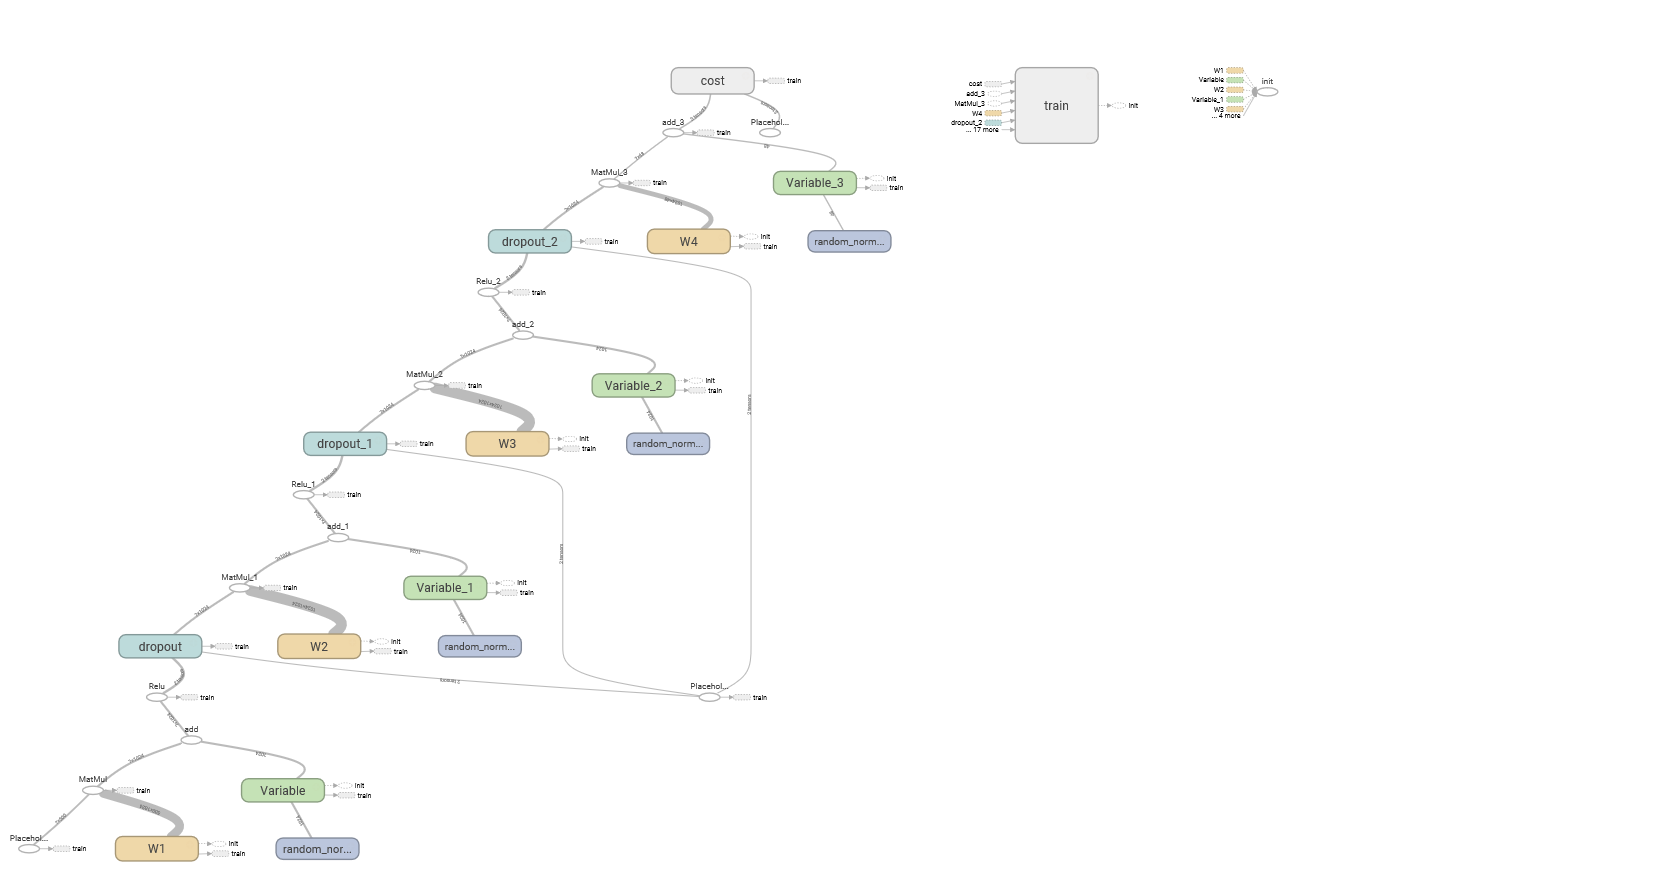

In [83]:
from IPython.display import Image
Image('images/graphs.png')

In [71]:
# AdamOptimizer 사용
with tf.name_scope("cost") as scope:
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
        logits=hypothesis, labels=Y))
    cost_summ = tf.summary.scalar("cost", cost)

with tf.name_scope("train") as scope:
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

In [72]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [73]:
# tensorboard --logdir=./logs/xor_logs

merged_summary = tf.summary.merge_all()
writer = tf.summary.FileWriter("./logs/naver_classificaion")
writer.add_graph(sess.graph)  # Show the graph
step=0

# train my model
for epoch in range(training_epochs):
    avg_cost = 0
    total_batch = int(len(train_x_np) / batch_size)

    for i in range(0, len(train_x_np), batch_size):

        batch_xs = train_x_np[i:i+batch_size]
        batch_ys = train_y_np[i:i+batch_size]

        feed_dict = {X: batch_xs, Y: batch_ys, keep_prob: 0.5}

        summary, c, _ = sess.run([merged_summary, cost, optimizer], feed_dict=feed_dict)
        avg_cost += c / total_batch
        step += 1
        writer.add_summary(summary, global_step=step)

    if epoch % 50 == 0:
        print('Epoch:', '%04d' % (epoch), 'cost =', '{:.9f}'.format(avg_cost))

print('Learning Finished!')

Epoch: 0000 cost = 1.549105932
Epoch: 0050 cost = 0.364310543
Epoch: 0100 cost = 0.299527836
Epoch: 0150 cost = 0.275463020
Epoch: 0200 cost = 0.261016350
Epoch: 0250 cost = 0.243347838
Epoch: 0300 cost = 0.235079613
Epoch: 0350 cost = 0.232609552
Epoch: 0400 cost = 0.235981395
Epoch: 0450 cost = 0.242230188
Learning Finished!


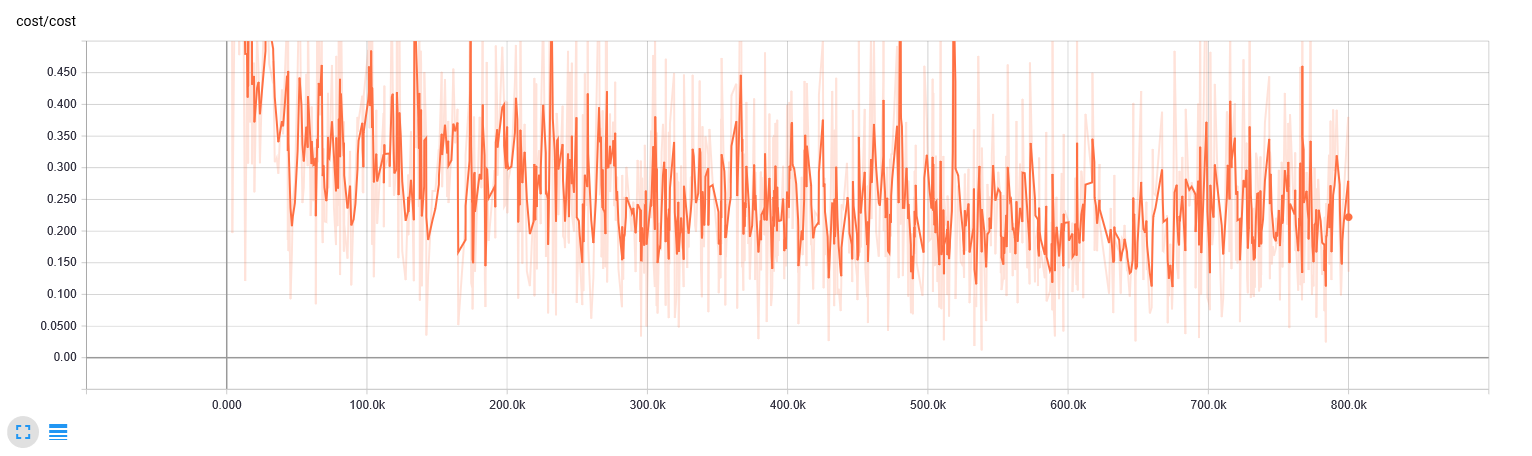

In [82]:
Image('images/cost.png')

In [80]:
# Test model and check accuracy
correct_prediction = tf.equal(tf.argmax(hypothesis, 1), tf.argmax(Y, 1))

accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [81]:
print('Accuracy:', sess.run(accuracy, feed_dict={
    X: test_x_np, Y: test_y_np, keep_prob: 1}))

Accuracy: 0.632954


In [76]:
# Get one and predict
r = random.randint(0, len(test_x_np) - 1)
print("Label: ", sess.run(tf.argmax(test_y_np[r:r + 1], 1)))

print("Prediction: ", sess.run(
        tf.argmax(hypothesis, 1),
        feed_dict={X: test_x_np[r:r + 1], keep_prob: 1}))

Label:  [11]
Prediction:  [11]


### Confustion Matrix

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

y_true = tf.placeholder(tf.float32, [None, 48])
y_pred = tf.placeholder(tf.float32, [None, 48])
y_true_cls = tf.placeholder(tf.int32, [None])

feed_dict_test = {X: test_x_np, Y: test_y_np, keep_prob: 1}

def print_confusion_matrix():
    cls_true = b[160000:]
    cls_pred = sess.run(tf.argmax(hypothesis, 1), feed_dict=feed_dict_test)
    cm = confusion_matrix(y_true=cls_true, y_pred=cls_pred)
    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.tight_layout()
    plt.colorbar()
    tick_marks = np.arange(48)
    plt.xticks(tick_marks, range(48))
    plt.yticks(tick_marks, range(48))
    plt.get_size_inches(forward=True)
    plt.xlabel('Predicted')
    plt.ylabel('True')

[[295  28  43 ...,   3   9   1]
 [ 19 166   3 ...,   0   0   0]
 [ 28   0 439 ...,   0   0   3]
 ..., 
 [  2   0   0 ..., 336  35  12]
 [  2   0   3 ...,  31 245  36]
 [  1   0   6 ...,  18  37 301]]


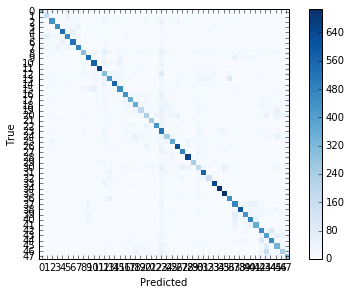

In [79]:
print_confusion_matrix()

## 결론

### 1만개 Sample 데이터로 훈련시켰을 때 Acc = 0.438  
### Full train 데이터로 훈령시켰을 때 Acc = 0.632   




## reference

### [[1]한국어와 NLTK, Gensim의 만남 ](https://www.lucypark.kr/slides/2015-pyconkr)
### [[2]파이썬으로 영어와 한국어 텍스트 다루기](https://www.lucypark.kr/courses/2015-dm/text-mining.html)
### [[3]머신러닝의 자연어 처리기술](https://www.slideshare.net/ssuser06e0c5/i-64267027)
### [[4]word2vec 관련 이론 정리](https://shuuki4.wordpress.com/2016/01/27/word2vec-%EA%B4%80%EB%A0%A8-%EC%9D%B4%EB%A1%A0-%EC%A0%95%EB%A6%AC/)